This file is used to produce Fig 3.3

YearPrediction.txt file contains the dataset. It is available through the link: https://archive-beta.ics.uci.edu/dataset/203/yearpredictionmsd

Reference: Bertin-Mahieux,T.. (2011). YearPredictionMSD. UCI Machine Learning Repository.

In [ ]:
# loading packages
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn import preprocessing
import scipy
from numpy import linalg as LA
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Global Varaible
Monte = 30                              #Monte_Carlo Numbers
m,d=(5000,90)                           #Data dimension
s = 515344                              #Dataset size
(dim_G,dim_P) = (91,91)                 #Subspace Dimension
width = 3                               #Gaussian Kernel Width
m_t = 3500                              #Training Set Size
m_e = 1500                              #Testing Set Size
index = range(0,m_t)                    #Index used for train-test split


In [3]:
# Optimal Recovery Map
def OR(Input_1,Kern_inv,Y_train,Input_2,Cross_kern):
    Output_1 = Y_train
    C = LA.inv(LA.multi_dot([np.transpose(Input_1),Kern_inv,Input_1]))
    Co_1 = LA.multi_dot([C,np.transpose(Input_1),Kern_inv,Output_1])
    Co_2 = LA.multi_dot([Kern_inv,(Output_1 - np.dot(Input_1,Co_1))])
    return np.dot(Input_2,Co_1) + np.dot(Cross_kern,Co_2)

In [4]:
# Simulation (It takes about 1 hr to run!!! Be patient!)
Er_KRR_GNG = np.zeros(shape = (Monte,1))
Error_Taylor_reg = np.zeros(shape = (dim_G,Monte))
Error_GNG = np.zeros(shape = (dim_G,Monte))

for k in range(0,Monte):
    index_sub = np.random.choice(s,m,replace = False)
    Data = pd.read_csv("YearPrediction.txt", sep = ",")         #Reading data, should be customized to read new data file.
    Data = pd.DataFrame(preprocessing.scale(Data))
    Data = Data.loc[index_sub]
    Data = Data.sort_values(by = [4])                           #Sorting data, should be customized to sort the data according to a different attributed.
    Dat = Data.to_numpy()
    Y = Dat[:,0]
    X = np.delete(Dat,0,axis = 1)
    D = distance.squareform(distance.pdist(X,'euclidean'))
    Kern_Gauss = np.exp(-D**2/(2*width**2))
    Kern_Gauss_inv = LA.inv(Kern_Gauss)
    Ex = np.zeros(shape = (m,1))
    for i in range(0,m):
        Ex[i] = np.exp(-LA.norm(X[i,:])**2/(2*width**2))
    L= (1/width)*Ex*X
    X_Taylor = np.hstack((Ex*np.ones(shape = (m,1)),L))
    (X_train,X_test)=(X[index,:],np.delete(X,index,0))
    (X_Taylor_train,X_Taylor_test)=(X_Taylor[index,:],np.delete(X_Taylor,index,0))
    (Y_train,Y_test)=(Y[index],np.delete(Y,index,0))
    D_train = distance.squareform(distance.pdist(X_train,'euclidean'))
    Kern_Gauss_train = np.exp(-D_train**2/(2*width**2))
    Kern_Gauss_train_inv = LA.inv(Kern_Gauss_train)
    CrossKern_Gauss = np.zeros(shape = (m_e,m_t))
    for i in range(0,m_e):
        for j in range(0,m_t):
            CrossKern_Gauss[i,j] = np.exp(-distance.euclidean(X_test[i],X_train[j])**2/(2*width**2))
    for i in range(0,dim_G):
        Error_GNG[i,k] = LA.norm(OR(X_Taylor_train[:,0:i],Kern_Gauss_train_inv,Y_train,X_Taylor_test[:,0:i],CrossKern_Gauss) - Y_test,ord = 2)/m_e
    Y_hat = LA.multi_dot([CrossKern_Gauss,Kern_Gauss_train_inv,Y_train])    
    Er_KRR_GNG[k] = LA.norm(Y_hat - Y_test,ord = 2)/m_e
    for i in range(0,dim_G):
        Error_Taylor_reg[i,k] = LA.norm(Y_test - LA.multi_dot([X_Taylor_test[:,0:i],LA.inv(np.dot(np.transpose(X_Taylor_train[:,0:i]),X_Taylor_train[:,0:i])),np.transpose(X_Taylor_train[:,0:i]),Y_train])  , ord = 2)/m_e         


In [5]:
# Output
print(Error_GNG)                    #The L-2 norm of the test error vector for Optimal Recovery. A dim(dim_G,Monte) array. Row i corresponds to Optimal Recovery error with subspace V of dimension i+1 for Monte number of simulations.
print(Error_Taylor_reg)             #The L-2 norm of the test error vector for Taylor feature regression. A dim(dim_G,Monte) array. Row i corresponds to Taylor feature regression error with space V of dimension i+1 for Monte number of simulations.
print(Er_KRR_GNG)                   #The L-2 norm of the test error vector for Gaussian kernel ridgeless regression. A dim(Monte,1) array. When the full dataset is being used, Monte = 1, this output become a number.

#%%Average OR Error
Error_GNG_avg = np.zeros(shape = (dim_G,1))
Error_GNG_ste = np.zeros(shape = (dim_G,1))
for i in range(0,dim_G):
    Error_GNG_avg[i] = np.mean(Error_GNG[i,:])
for i in range(0,dim_G):
    Error_GNG_ste[i] = np.std(Error_GNG[i,:])/Monte


[[0.02326529 0.02392872 0.02303722 ... 0.02549837 0.02584807 0.0243451 ]
 [0.02326138 0.02392977 0.02303735 ... 0.02549735 0.02584883 0.02434422]
 [0.02323084 0.02389494 0.02297765 ... 0.02540148 0.02581774 0.02423989]
 ...
 [0.02320551 0.02403565 0.02299847 ... 0.02526515 0.02591766 0.02422969]
 [0.02320896 0.02405548 0.02299758 ... 0.02525558 0.02591887 0.02423031]
 [0.02320697 0.02405928 0.02299638 ... 0.02525705 0.0259179  0.02423908]]
[[0.025463   0.02623319 0.02544683 ... 0.0276764  0.02733426 0.02690905]
 [0.02542434 0.02614257 0.02543486 ... 0.0276788  0.02738137 0.02685984]
 [0.02456408 0.02513233 0.02454636 ... 0.02671867 0.02657665 0.02560633]
 ...
 [0.02337156 0.02433981 0.0232744  ... 0.02528378 0.02584524 0.02446903]
 [0.023398   0.02436356 0.0232767  ... 0.02528425 0.02584753 0.02448216]
 [0.02339143 0.02436442 0.02328026 ... 0.02528266 0.02584469 0.02448714]]
[[0.02326529]
 [0.02392872]
 [0.02303722]
 [0.02327211]
 [0.02356971]
 [0.0254848 ]
 [0.02374987]
 [0.02450367]


In [6]:
#%%Average Taylor Regression Error
Error_Taylor_avg = np.zeros(shape = (dim_G,1))
Error_Taylor_ste = np.zeros(shape = (dim_G,1))
for i in range(0,dim_G):
    Error_Taylor_avg[i] = np.mean(Error_Taylor_reg[i,:])
    
for i in range(0,dim_G):
    Error_Taylor_ste[i] = np.std(Error_Taylor_reg[i,:])/Monte
    
#%%Average Kernel Ridgeless Regression
Er_KRR_avg = np.mean(Er_KRR_GNG)*np.ones(shape = (dim_G,1))
Er_KRR_ste = np.std(Er_KRR_GNG)/Monte*np.ones(shape = (dim_G,1))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpa

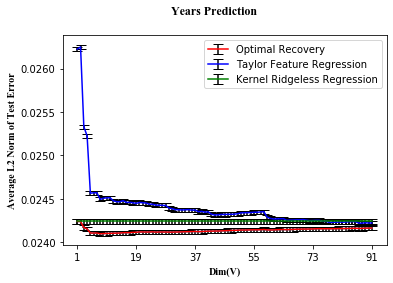

In [7]:
#%%Generating Plot
Xlabel = range(1,92)
plt.plot(Xlabel,Error_GNG_avg)
plt.errorbar(Xlabel, Error_GNG_avg, yerr=Error_GNG_ste, color='red', capsize=5, capthick=1, ecolor='black',label = 'Optimal Recovery')
plt.errorbar(Xlabel, Error_Taylor_avg, yerr=Error_Taylor_ste, color='blue', capsize=5, capthick=1, ecolor='black',label = 'Taylor Feature Regression')
plt.errorbar(Xlabel, Er_KRR_avg, yerr=Er_KRR_ste, color='green', capsize=5, capthick=1, ecolor='black',label = 'Kernel Ridgeless Regression')
plt.xticks([1,19,37,55,73,91])
plt.ylabel('Average L2 Norm of Test Error',fontname="Times New Roman")
plt.xlabel('Dim(V)',fontname="Times New Roman")
plt.suptitle('Years Prediction',fontname="Times New Roman")
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15,left = 0.15)
plt.savefig("Year_Taylor.eps",format = 'eps')
plt.savefig("Year_Taylor.png",format = 'png')